In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.weightedEDFs as wEDFs
import src.binning as binning

import random

import matplotlib.patches as patches

import seaborn as sns
import matplotlib.colors as colors

import matplotlib as mpl

# Heat Equation Convergence

This notebook covers the code and plotting scripts used to create the heat equation convergence example (Section 5.1) from the paper.

In [3]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5


CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

## Problem setup

The setup for this problem is described in Section 2.4 of the paper. To assess convergence, it is necessary to run each case with multiple trials. This process can take a long time, so the following cell allows you to set "rerun_densities" and "rerun_distributions" to false and use data from pre-run computations. If you set the booleans below to "True", the trials will be rerun, and the notebook will take significantly more time to run.

In [4]:
rerun_densities = False
rerun_distributions = False

In [5]:
random.seed(10)

In [6]:
l = 2.
kappa = 1.

In [7]:
N = 100  # Specify the truncation
x = np.linspace(0, l, 2*N)

In [8]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

In [9]:
t = .01
sensor_loc = 1.2

In [10]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

## Convergence analysis

To analyze the convergence, we define two sets: set $B$ in the output space, and set $A$ on the parameter space, as shown in Figure 11.

In [11]:
low_x = 2.01
upp_x = 2.02
low_y = 0.95
upp_y = 1.0

upp_B = u(N, sensor_loc, t, low_x, low_y)
low_B = u(N, sensor_loc, t, upp_x, upp_y)

delta_l = 0.1
delta_kappa = 0.5

print(f'Upper bound of B = {upp_B}')
print(f'Lower bound of B = {low_B}')

Upper bound of B = 0.5935544013268559
Lower bound of B = 0.5899603114552461


In [12]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, t, XX[count,:], YY[count,:])

In [13]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 100000
obs_samples = obs_dist.rvs(n_obs_samples)

d_min = np.min(ZZ)
d_max = np.max(ZZ)

obs_KDE = GKDE(obs_samples)

## Density computation of probability of $A$

The compute the "true" probability of the set $A$, we use the density-based method. We run the method with many initial samples, and run multiple trials, in order to get an accurate approximation.

In [14]:
n_init_samples = 100000

In [15]:
n_density_trials = 50

In [16]:
if rerun_densities:

    true_up_prob_set = []
    for trial in range(n_density_trials):

        print(f'working on trial {trial}')

        init_samples = np.random.uniform(0, 1, (n_init_samples,2))
        init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
        init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

        pred_samples = np.zeros((n_init_samples, 1))
        pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
        pred_KDE = GKDE(pred_samples[:,0])

        r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
        rn_w = r / n_init_samples

        true_up_prob_set.append(0)
        for i, isamp in enumerate(init_samples):
            if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                true_up_prob_set[int(trial)] += rn_w[i]
                
    np.save('./data/convergence_dens_prob_A.npy', np.array(true_up_prob_set))

else:

    init_samples = np.random.uniform(0, 1, (n_init_samples,2))
    init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
    init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

    pred_samples = np.zeros((n_init_samples, 1))
    pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    pred_KDE = GKDE(pred_samples[:,0])

    r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
    rn_w = r / n_init_samples

    true_up_prob_set = np.load('./data/convergence_dens_prob_A.npy')

obs_prob_set = 0
for osamp in obs_samples:
    if osamp >= low_B and osamp <= upp_B:
        obs_prob_set += 1 / n_obs_samples

true_up_prob_set = np.mean(true_up_prob_set)

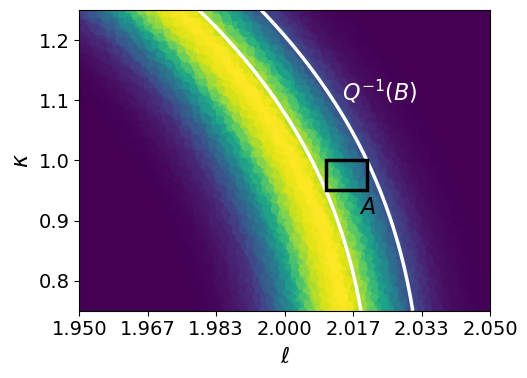

In [17]:
ax = plt.gca()

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples);

plt.contour(XX, YY, ZZ, levels=[low_B, upp_B], colors=['w', 'w']);

set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='k',
                          fill=None, zorder=10, linewidth=2.5);
ax.add_patch(set_A);

plt.text(upp_x-0.002, low_y-0.04, r'$A$', fontsize=16);
plt.text(upp_x-0.006, upp_y+0.1, r'$Q^{-1}(B)$', fontsize=16, color='w');

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 7)]);

plt.tight_layout();
plt.savefig(f'{plot_directory}/sets_Lambda.png', bbox_inches='tight');

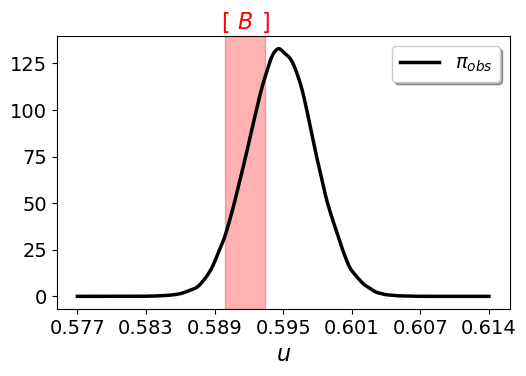

In [18]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$', color='k');
plt.yticks(fontsize=14);
plt.text((upp_B-low_B)/2 + low_B, 147, r'$B$', color='r', fontsize=16,
         horizontalalignment='center', verticalalignment='center');
plt.text(low_B, 147, r'$[$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center');
plt.text(upp_B, 147, r'$]$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center');
plt.axvspan(low_B, upp_B, alpha=0.3, color='r');

plt.legend(loc='upper right', shadow=True);
plt.xlabel(r'$u$');
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)], color='k');

plt.tight_layout()
plt.savefig(f'{plot_directory}/sets_D.png', bbox_inches='tight')

In [19]:
bin_numbers = [20, 40, 60, 80, 100, 120, 140, 160]
init_samples_numbers = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [ ]:
comp_prob_A = []
comp_prob_B = []
count_A = []
count_B = []

init_samples_full = np.random.uniform(0, 1, (init_samples_numbers[-1],2))
init_samples_full[:,0] = init_samples_full[:,0] * delta_l + l - delta_l / 2
init_samples_full[:,1] = init_samples_full[:,1] * delta_kappa + kappa - delta_kappa / 2
pred_samples_full = np.zeros((init_samples_numbers[-1], 1))
pred_samples_full[:, 0] = u(N, sensor_loc, t, init_samples_full[:,0], init_samples_full[:,1])

for i, n_init_samples in enumerate(init_samples_numbers):

    comp_prob_A.append([])
    comp_prob_B.append([])

    init_samples = init_samples_full[:n_init_samples,:]
    pred_samples = pred_samples_full[:n_init_samples,:]

    for b, n_bins in enumerate(bin_numbers):

        rpartitioned_w, bins, centers, w_center = binning.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                                pred_samples, bbox=[d_min,d_max],
                                                                                sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                                n_bins=n_bins)

        weight_set = 0
        count_in_B = 0
        for count, psamp in enumerate(pred_samples): 
            if psamp >= low_B and psamp <= upp_B:
                weight_set += rpartitioned_w[count]
                count_in_B += 1

        centers_in_B = 0
        for center in centers:
            if center >= low_B and center <= upp_B:
                centers_in_B += 1

        up_prob_set = 0
        count_in_A = 0
        for count, isamp in enumerate(init_samples):
            if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                count_in_A += 1 
                up_prob_set += rpartitioned_w[count]

        comp_prob_B[i].append(weight_set)
        comp_prob_A[i].append(up_prob_set)

    count_B.append(count_in_B)
    count_A.append(count_in_A)

     pcost       dcost       gap    pres   dres
 0: -2.0512e-01 -2.0262e+01  2e+01  2e-16  9e+00
 1: -2.0523e-01 -4.6138e-01  3e-01  1e-15  1e-01
 2: -2.1158e-01 -2.5576e-01  4e-02  7e-16  2e-02
 3: -2.2554e-01 -2.4624e-01  2e-02  3e-15  2e-17
 4: -2.2720e-01 -2.3078e-01  4e-03  1e-15  1e-17
 5: -2.2797e-01 -2.2858e-01  6e-04  9e-16  1e-17
 6: -2.2809e-01 -2.2816e-01  7e-05  1e-15  1e-17
 7: -2.2811e-01 -2.2812e-01  1e-05  8e-16  2e-17
 8: -2.2811e-01 -2.2812e-01  2e-06  1e-15  1e-17
 9: -2.2811e-01 -2.2811e-01  2e-07  9e-16  2e-17
10: -2.2811e-01 -2.2811e-01  4e-08  1e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0632e-01 -4.0262e+01  4e+01  5e-17  1e+01
 1: -2.0637e-01 -6.6192e-01  5e-01  1e-15  1e-01
 2: -2.1022e-01 -2.6137e-01  5e-02  1e-15  2e-02
 3: -2.2635e-01 -2.5412e-01  3e-02  2e-15  1e-17
 4: -2.2793e-01 -2.3170e-01  4e-03  2e-15  2e-17
 5: -2.2877e-01 -2.2971e-01  9e-04  2e-15  2e-17
 6: -2.2891e-01 -2.2907e-01  2e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

In [20]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for count, b in enumerate(comp_prob_B):
    row_string = f'{init_samples_numbers[count]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of B = {obs_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.25893  0.26406  0.26597  0.26845  0.26825  0.27211  0.26993  0.27118  
 2000   0.25966  0.26171  0.26369  0.26573  0.26407  0.26972  0.26781  0.26943  
 3000   0.26236  0.26556  0.26648  0.26704  0.26678  0.27178  0.26918  0.27106  
 4000   0.26543  0.26761  0.26826  0.26866  0.26845  0.27006  0.26971  0.27034  
 5000   0.26683  0.26701  0.26912  0.26972  0.26857  0.26904  0.26970  0.27084  
 6000   0.26722  0.26713  0.26831  0.26804  0.26748  0.26729  0.26892  0.27011  
 7000   0.26537  0.26606  0.26682  0.26675  0.26620  0.26756  0.26884  0.26994  
 8000   0.26497  0.26597  0.26690  0.26619  0.26568  0.26689  0.26877  0.26956  
 9000   0.26503  0.26638  0.26741  0.26677  0.26636  0.26697  0.26862  0.26937  
10000   0.26459  0.26625  0.26774  0.26726  0.26673  0.26723  0.26880  0.26928  

actual probability of B = 0.26760


In [21]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for count, b in enumerate(comp_prob_B):
    row_string = f'{init_samples_numbers[count]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{np.abs(i-obs_prob_set):.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of B = {obs_prob_set:0.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.00867  0.00354  0.00163  0.00085  0.00065  0.00451  0.00233  0.00358  
 2000   0.00794  0.00589  0.00391  0.00187  0.00353  0.00212  0.00021  0.00183  
 3000   0.00524  0.00204  0.00112  0.00056  0.00082  0.00418  0.00158  0.00346  
 4000   0.00217  0.00001  0.00066  0.00106  0.00085  0.00246  0.00211  0.00274  
 5000   0.00077  0.00059  0.00152  0.00212  0.00097  0.00144  0.00210  0.00324  
 6000   0.00038  0.00047  0.00071  0.00044  0.00012  0.00031  0.00132  0.00251  
 7000   0.00223  0.00154  0.00078  0.00085  0.00140  0.00004  0.00124  0.00234  
 8000   0.00263  0.00163  0.00070  0.00141  0.00192  0.00071  0.00117  0.00196  
 9000   0.00257  0.00122  0.00019  0.00083  0.00124  0.00063  0.00102  0.00177  
10000   0.00301  0.00135  0.00014  0.00034  0.00087  0.00037  0.00120  0.00168  

actual probability of B = 0.26760


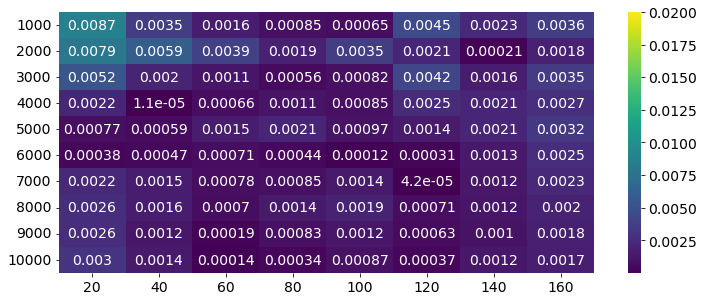

In [22]:
plt.figure(figsize=(12,4.8))

sns.heatmap(np.abs(np.array(comp_prob_B)-obs_prob_set), annot=True, cmap='viridis',
            yticklabels=init_samples_numbers, xticklabels=bin_numbers, vmax=0.02);

In [23]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(comp_prob_A):
    row_string = f'{init_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of A = {true_up_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.02706  0.02425  0.02442  0.02426  0.02290  0.02373  0.02439  0.02384  
 2000   0.02212  0.02085  0.02043  0.02092  0.02077  0.02077  0.02040  0.02015  
 3000   0.02051  0.01963  0.01950  0.01940  0.01968  0.01986  0.01976  0.01966  
 4000   0.02077  0.02063  0.02036  0.02046  0.02041  0.02050  0.02106  0.02117  
 5000   0.02165  0.02139  0.02125  0.02134  0.02128  0.02120  0.02187  0.02197  
 6000   0.02067  0.02045  0.02032  0.02041  0.02016  0.02029  0.02051  0.02088  
 7000   0.02132  0.02116  0.02096  0.02123  0.02091  0.02096  0.02119  0.02168  
 8000   0.02071  0.02071  0.02070  0.02088  0.02056  0.02069  0.02091  0.02133  
 9000   0.02216  0.02225  0.02203  0.02230  0.02190  0.02208  0.02238  0.02263  
10000   0.02078  0.02092  0.02066  0.02097  0.02069  0.02071  0.02104  0.02124  

actual probability of A = 0.01990


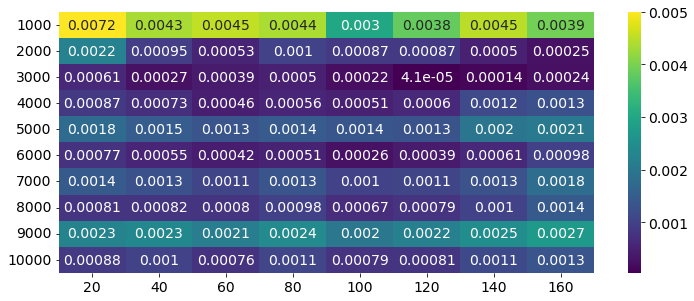

In [24]:
plt.figure(figsize=(12,4.8))

sns.heatmap(np.abs(np.array(comp_prob_A)-true_up_prob_set), annot=True, cmap='viridis',
            yticklabels=init_samples_numbers, xticklabels=bin_numbers, vmax=0.005);

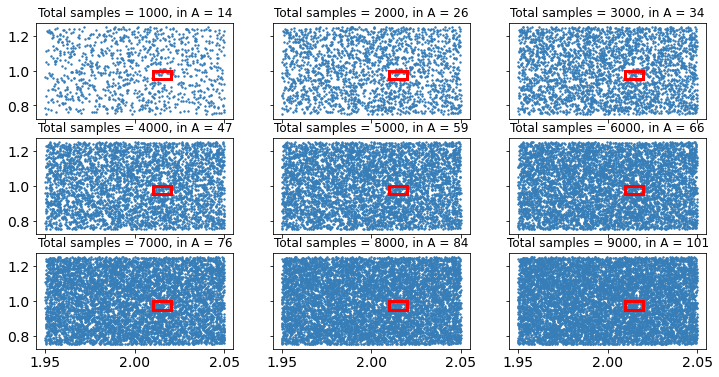

In [25]:
f, axs = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12,6))

for i in range(3):
    for j in range(3):
        
        n_init_samples = init_samples_numbers[i * 3 + j]

        set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='r', fill=None, linewidth=3)
        axs[i,j].add_patch(set_A)
        axs[i,j].scatter(init_samples[:n_init_samples,0], init_samples[:n_init_samples,1], s=2)
        axs[i,j].set_title(f'Total samples = {n_init_samples}, in A = {count_A[i * 3 + j]}', fontsize=12)

In [26]:
n_trials = 100

In [27]:
if rerun_distributions == True:

    c_A = []
    c_B = []

    for trial in range(n_trials):
        
        print(f'working on trial {trial}')

        comp_prob_A = []
        comp_prob_B = []

        init_samples_full = np.random.uniform(0, 1, (init_samples_numbers[-1], 2))
        init_samples_full[:,0] = init_samples_full[:,0] * delta_l + l - delta_l / 2
        init_samples_full[:,1] = init_samples_full[:,1] * delta_kappa + kappa - delta_kappa / 2

        pred_samples_full = np.zeros((init_samples_numbers[-1], 1))
        pred_samples_full[:, 0] = u(N, sensor_loc, t, init_samples_full[:,0], init_samples_full[:,1])

        for i, n_init_samples in enumerate(init_samples_numbers):

            comp_prob_A.append([])
            comp_prob_B.append([])

            init_samples = init_samples_full[:n_init_samples,:]

            pred_samples = pred_samples_full[:n_init_samples,:]
            pred_KDE = GKDE(pred_samples[:,0])

            for b, n_bins in enumerate(bin_numbers):

                rpartitioned_w, bins, centers, w_center = binning.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                                        pred_samples, bbox=[d_min, d_max],
                                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                                        n_bins=n_bins)

                weight_set = 0
                for count, psamp in enumerate(pred_samples): 
                    if psamp >= low_B and psamp <= upp_B:
                        weight_set += rpartitioned_w[count]

                up_prob_set = 0
                for count, isamp in enumerate(init_samples):
                    if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                        up_prob_set += rpartitioned_w[count]

                comp_prob_B[i].append(weight_set)
                comp_prob_A[i].append(up_prob_set)

        c_A.append(comp_prob_A)
        c_B.append(comp_prob_B)

    dist_prob_A = np.array(c_A)
    dist_prob_B = np.array(c_B)

    np.save('./data/convergence_dist_prob_A.npy', dist_prob_A.reshape(n_trials, -1))
    np.save('./data/convergence_dist_prob_B.npy', dist_prob_B.reshape(n_cases, -1))
    
else:

    dist_prob_A = np.load('./data/convergence_dist_prob_A.npy').reshape(n_trials,
                                                                        len(init_samples_numbers),
                                                                        len(bin_numbers))
    dist_prob_B = np.load('./data/convergence_dist_prob_B.npy').reshape(n_trials,
                                                                        len(init_samples_numbers),
                                                                        len(bin_numbers))

working on trial 0
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01 

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-

 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-

 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138

10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940

 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138

 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537

 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-

 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-

 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103

 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost

 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost

 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost

 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-

 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-

 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537

 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579

 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-

 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615

 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262

 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138

 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-

 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost

 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398

 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
working on trial 44
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4:

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-

 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
working on trial 61
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4:

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103

10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941

 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-

 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101

 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537

 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-

 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-

 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615

 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026

 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839

 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026

 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-

 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975

 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-

 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
working on trial 84
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01

10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost

 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615

 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839

 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-

10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940

 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101

     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-1

 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261

 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-1

 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-

 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-1

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-18
 7: -2.2908e-01 -2.2909e-01  1e-05  3e-15  5e-18
 8: -2.2908e-01 -2.2908e-01  2e-06  3e-15  9e-18
 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-1

     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-18
 7: -2.2897e-01 -2.2899e-01  1e-05  3e-15  7e-18
 8: -2.2898e-01 -2.2898e-01  2e-06  4e-15  6e-18
 9: -2.2898e-01 -2.2898e-01  4e-07  2e-15  1e-17
10: -2.2898e-01 -2.2898e-01  8e-08  4e-15  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-1

     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-1

     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101e-01  3e-03  5e-15  5e-18
 5: -2.2899e-01 -2.2943e-01  4e-04  4e-15  6e-18
 6: -2.2911e-01 -2.2918e-01  7e-05  5e-15  4e-18
 7: -2.2913e-01 -2.2914e-01  1e-05  4e-15  5e-18
 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
working on trial 99
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01

 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368e-01  3e-02  2e-15  1e-17
 4: -2.2762e-01 -2.3138e-01  4e-03  2e-15  1e-17
 5: -2.2846e-01 -2.2940e-01  9e-04  2e-15  8e-18
 6: -2.2860e-01 -2.2876e-01  2e-04  1e-15  9e-18
 7: -2.2863e-01 -2.2866e-01  2e-05  3e-15  7e-18
 8: -2.2864e-01 -2.2864e-01  5e-06  2e-15  8e-18
 9: -2.2864e-01 -2.2864e-01  9e-07  2e-15  7e-18
10: -2.2864e-01 -2.2864e-01  2e-07  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432

 8: -2.2913e-01 -2.2913e-01  2e-06  4e-15  8e-18
 9: -2.2913e-01 -2.2913e-01  3e-07  5e-15  4e-18
10: -2.2913e-01 -2.2913e-01  6e-08  5e-15  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0486e-01 -2.0261e+01  2e+01  4e-16  9e+00
 1: -2.0497e-01 -4.6099e-01  3e-01  9e-16  1e-01
 2: -2.1131e-01 -2.5537e-01  4e-02  6e-16  2e-02
 3: -2.2522e-01 -2.4579e-01  2e-02  2e-15  1e-17
 4: -2.2688e-01 -2.3045e-01  4e-03  2e-15  9e-18
 5: -2.2765e-01 -2.2824e-01  6e-04  1e-15  1e-17
 6: -2.2777e-01 -2.2784e-01  7e-05  1e-15  1e-17
 7: -2.2779e-01 -2.2780e-01  1e-05  2e-15  1e-17
 8: -2.2779e-01 -2.2779e-01  2e-06  1e-15  2e-17
 9: -2.2779e-01 -2.2779e-01  3e-07  5e-16  1e-17
10: -2.2779e-01 -2.2779e-01  4e-08  2e-15  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0607e-01 -4.0262e+01  4e+01  2e-16  1e+01
 1: -2.0612e-01 -6.6155e-01  5e-01  2e-15  1e-01
 2: -2.0996e-01 -2.6101e-01  5e-02  1e-15  2e-02
 3: -2.2604e-01 -2.5368

 9: -2.2908e-01 -2.2908e-01  3e-07  4e-15  1e-17
10: -2.2908e-01 -2.2908e-01  6e-08  4e-15  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0686e-01 -1.4026e+02  1e+02  4e-16  2e+01
 1: -2.0688e-01 -1.6615e+00  1e+00  2e-15  2e-01
 2: -2.0820e-01 -2.7398e-01  7e-02  2e-15  1e-02
 3: -2.2562e-01 -2.4975e-01  2e-02  3e-15  5e-18
 4: -2.2822e-01 -2.3103e-01  3e-03  4e-15  5e-18
 5: -2.2897e-01 -2.2940e-01  4e-04  3e-15  4e-18
 6: -2.2909e-01 -2.2916e-01  7e-05  5e-15  6e-18
 7: -2.2910e-01 -2.2912e-01  1e-05  4e-15  8e-18
 8: -2.2911e-01 -2.2911e-01  2e-06  4e-15  6e-18
 9: -2.2911e-01 -2.2911e-01  3e-07  4e-15  4e-18
10: -2.2911e-01 -2.2911e-01  6e-08  4e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0690e-01 -1.6026e+02  2e+02  6e-16  3e+01
 1: -2.0691e-01 -1.8615e+00  2e+00  3e-15  3e-01
 2: -2.0808e-01 -2.7615e-01  7e-02  2e-15  1e-02
 3: -2.2537e-01 -2.4839e-01  2e-02  3e-15  6e-18
 4: -2.2824e-01 -2.3101

     pcost       dcost       gap    pres   dres
 0: -2.0674e-01 -1.0026e+02  1e+02  7e-16  2e+01
 1: -2.0676e-01 -1.2615e+00  1e+00  2e-15  2e-01
 2: -2.0855e-01 -2.6946e-01  6e-02  2e-15  1e-02
 3: -2.2606e-01 -2.5250e-01  3e-02  2e-15  8e-18
 4: -2.2815e-01 -2.3114e-01  3e-03  5e-15  5e-18
 5: -2.2890e-01 -2.2942e-01  5e-04  5e-15  6e-18
 6: -2.2902e-01 -2.2910e-01  8e-05  3e-15  7e-18
 7: -2.2904e-01 -2.2905e-01  1e-05  3e-15  5e-18
 8: -2.2904e-01 -2.2904e-01  2e-06  3e-15  5e-18
 9: -2.2904e-01 -2.2904e-01  4e-07  3e-15  8e-18
10: -2.2904e-01 -2.2904e-01  7e-08  3e-15  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -1.2026e+02  1e+02  3e-16  2e+01
 1: -2.0683e-01 -1.4615e+00  1e+00  2e-15  2e-01
 2: -2.0835e-01 -2.7176e-01  6e-02  2e-15  1e-02
 3: -2.2586e-01 -2.5114e-01  3e-02  3e-15  5e-18
 4: -2.2819e-01 -2.3107e-01  3e-03  3e-15  7e-18
 5: -2.2894e-01 -2.2941e-01  5e-04  4e-15  8e-18
 6: -2.2906e-01 -2.2913e-01  7e-05  4e-15  5e-1

     pcost       dcost       gap    pres   dres
 0: -2.0645e-01 -6.0262e+01  6e+01  5e-16  2e+01
 1: -2.0648e-01 -8.6158e-01  7e-01  2e-15  2e-01
 2: -2.0925e-01 -2.6432e-01  6e-02  1e-15  1e-02
 3: -2.2624e-01 -2.5444e-01  3e-02  2e-15  9e-18
 4: -2.2791e-01 -2.3139e-01  3e-03  2e-15  7e-18
 5: -2.2871e-01 -2.2948e-01  8e-04  2e-15  9e-18
 6: -2.2884e-01 -2.2897e-01  1e-04  2e-15  1e-17
 7: -2.2887e-01 -2.2889e-01  2e-05  3e-15  7e-18
 8: -2.2887e-01 -2.2887e-01  3e-06  3e-15  7e-18
 9: -2.2887e-01 -2.2887e-01  6e-07  3e-15  1e-17
10: -2.2887e-01 -2.2887e-01  1e-07  3e-15  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0663e-01 -8.0262e+01  8e+01  3e-16  2e+01
 1: -2.0666e-01 -1.0616e+00  9e-01  2e-15  2e-01
 2: -2.0883e-01 -2.6702e-01  6e-02  2e-15  1e-02
 3: -2.2620e-01 -2.5371e-01  3e-02  2e-15  6e-18
 4: -2.2807e-01 -2.3125e-01  3e-03  4e-15  6e-18
 5: -2.2883e-01 -2.2942e-01  6e-04  3e-15  5e-18
 6: -2.2895e-01 -2.2905e-01  9e-05  3e-15  5e-1

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
mean_dist_prob_A = np.mean(dist_prob_A, axis=0)
mean_dist_prob_B = np.mean(dist_prob_B, axis=0)

In [ ]:
plt.figure(figsize=(12,4.8));

s = sns.heatmap(np.abs(mean_dist_prob_B-obs_prob_set), annot=True, cmap='viridis', fmt='0.2E',
            yticklabels=init_samples_numbers, xticklabels=bin_numbers,
            norm=colors.LogNorm(vmin=np.min(np.abs(mean_dist_prob_B-obs_prob_set)),
                                vmax=np.max(np.abs(mean_dist_prob_B-obs_prob_set))));
s.set_xlabel('$p$');
s.set_ylabel('$n$');

plt.tight_layout();
plt.savefig(f'{plot_directory}/heatmap_meanB.png', bbox_inches='tight');

In [ ]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(mean_dist_prob_A-true_up_prob_set), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=init_samples_numbers, xticklabels=bin_numbers,
                norm=colors.LogNorm(vmin=np.min(np.abs(mean_dist_prob_A-true_up_prob_set)),
                                    vmax=np.max(np.abs(mean_dist_prob_A-true_up_prob_set))));


s.set_xlabel('$p$')
s.set_ylabel('$n$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heatmap_meanA.png', bbox_inches='tight')

In [ ]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(mean_dist_prob_A):
    row_string = f'{init_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of A = {true_up_prob_set:.5f}')

In [ ]:
std_dist_prob_A = np.std(dist_prob_A, axis=0)
std_dist_prob_B = np.std(dist_prob_B, axis=0)

In [ ]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(std_dist_prob_B)), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=init_samples_numbers, xticklabels=bin_numbers);

s.set_xlabel(r'$p$');
s.set_ylabel(r'$n$');

plt.tight_layout();
plt.savefig(f'{plot_directory}/heatmap_stdB.png', bbox_inches='tight');

In [ ]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(std_dist_prob_A)), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=init_samples_numbers, xticklabels=bin_numbers);
s.set_xlabel(r'$p$');
s.set_ylabel(r'$n$');

plt.tight_layout()
plt.savefig(f'{plot_directory}/heatmap_stdA.png', bbox_inches='tight');